# Jax入坑指南系列(六): Flax MNIST数据集实战

在之前的文章，我们介绍如何用jax或flax搭建MLP神经网络框架来解决mnist手写数字图片的多分类问题。
而今天的文章，我们通过mnist数据进行flax进阶训练，通过mnist数据集如何像专家一样搭建专业的CNN多分类模型。

我们今天将包含如下内容:
  1. flax的卷积神经网络模型(CNN)搭建。
  2. optax优化库进阶使用。
  3. training-loop框架的搭建。

## Recap: flax MLP模型框架
在前面的flax神经网络中，我们通过flax里的***flaxlinen**内置nn.Module搭建了一个分多类的MLP模型, 其中：

In [1]:
!pip install optax==0.1.7 flax ml_collections clu

In [2]:
# Python libs
import functools  
from typing import Any, Callable, Sequence, Optional

import numpy as np

import jax
from jax import lax, jit, random, numpy as jnp

import optax

import matplotlib.pyplot as plt

In [3]:
from flax import linen as nn 
class flaxMLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for i, feat in enumerate(self.features):
            x = nn.Dense(feat, name=f'layers_{i}')(x)
            if i != len(self.features) - 1:
                x = nn.relu(x)
        x = nn.log_softmax(x)
        return x

其中:

   1. nn.Module与其他神经网络模型(如pytorch).nn.Module类似，是一个dataclass
   2. __call__等价于pytorch中的forward函数: 给定input输出预测结果。
   3. 在最后一层我们通过nn.log_softmax实现了交叉熵损失(cross-entropy loss)用于多分类问题。

在flax框架中 ,一个通用的神经网络的执行，包含两个步骤:
    1. 初始化(init): 初始化神经网络的参数值集，可以是基于梯度下降的方法找到更优的参数集结果。
    2. 应用(apply): 通过类似函数式编程里apply的方式实现预测(矩阵乘积的方式)。
    
下面是一个简单的实现，我们通过random.split生成两个key用于仿真数据与模型的state。

In [4]:
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (128,784))

model = flaxMLP(features=[784, 512, 256, 10])

In [5]:
params = model.init(key2, x)
y = model.apply(params, x)

## optax优化库进阶
在前面，我们展示了如何使用optax库里梯度下降算法来对神经网络模型的参数进行迭代训练:

In [6]:
lr=0.01
opt_sgd = optax.sgd(learning_rate=lr)
opt_state = opt_sgd.init(params)

一个简单的优化我们可以用adam优化器来替换我们上述的sgd:

In [7]:
opt_adam = optax.adam(learning_rate=lr)
opt_state = opt_adam.init(params)  
# always the same pattern - handling state externally

接下来可以尝试optax优化库里的高级功能，比如我们可以在上述的基础上结合学习率调度器(learning rate sceduler),optax的chaining,param freezing等模块，构造出更强大复杂的训练框架(trainer),比如下面是flax-example中ImageNet的学习率调度器的实现:

In [8]:
#!pip install ml_collections
import ml_collections
# Example from Flax (ImageNet example): https://github.com/google/flax/blob/main/examples/imagenet/train.py#L88
def learning_rate_fn(
    config: ml_collections.ConfigDict,
    base_learning_rate: float,
    steps_per_epoch: int):
    """Create learning rate schedule."""
    warmup_fn = optax.linear_schedule(init_value=0., end_value=base_learning_rate,
        transition_steps=config.warmup_epochs * steps_per_epoch)
    
    cosine_epochs = max(config.num_epochs - config.warmup_epochs, 1)
    cosine_fn = optax.cosine_decay_schedule(init_value=base_learning_rate,
      decay_steps=cosine_epochs * steps_per_epoch)
    
    schedule_fn = optax.join_schedules(schedules=[warmup_fn, cosine_fn],
      boundaries=[config.warmup_epochs * steps_per_epoch])
    return schedule_fn

tx = optax.sgd(
      learning_rate=learning_rate_fn,
      momentum=0.9,
      nesterov=True,)

对于一阶优化求解器，我们其主要优化因素: 一是每次迭代的步长(学习率), 二是每次迭代的方向。
在上述代码中，我们使用了optax里momentum优化求解器, 一个基本momentum求解器的基本原理是学习率固定，每次迭代的方向选择使用历史梯度序列的指数衰减平均。
上述代码中，我们在momentum的基础上搭建了一个学习率调度器(learning rate scheduler),动态地调整每次的步长或学习率;具体而言，
我们在开始阶段(warm-up stage)线性衰减，然后在接下使用cosine学习率。

### optax损失函数功能
在optax库中，另一类常用的模块就是损失功能，在前面的MLP网络中，我们通过:
   1. 最后一层我nn.log_softmax log-softmax变换
   2. 对0到9进行one-hot-encoding变换实现了交叉熵(cross-entropy loss)。
基于optax的损失函数模块，我们可以直接调用**optax.softmax_cross_entropy_with_integer_labels**模块实现上述功能

## 卷积神经网络(CNN)
一个经典的CNN-block实现是如"conv-relu-avg_pool"的卷积特征提取层,在flax中

In [9]:
# lots of hardcoding, but it serves a purpose for a simple demo
class CNN(nn.Module): 
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        #x = nn.log_softmax(x)
         # 将使用optax.softmax_cross_entropy_with_integer_labels, 不需要log-softmax变换。
        return x

我们可以用flax中tabulate功能对其进行可视化

In [10]:
cnn = CNN()
print(cnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1))))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,… │ float32[1,10]     │                   │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_0  │ Conv   │ float32[1,28,28,… │ float32[1,28,28,… │ bias: float32[32] │
│         │        │                   │                   │ kernel:           │
│         │        │                   │                   │ float32[3,3,1,32] │
│         │        │                   │                   │                   │
│         │        │                   │                   │ 320 (1.3 KB)      │
├─────────┼────────┼───────────────────┼───────────────────┼───────────────────┤
│ Conv_1  │ Conv   │ float3

可以看到，上述代码与先前最大的区别在于，在输入的层中，我们多了两层"conv-relu-avg_pool"的卷积特征提取层。
同时， 在输入数据侧，我们需要将之前<1,784>的图片格式转成<1,28,28>适合cnn提取的格式。

## 数据准备

In [11]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

##转成(28,28,1)
def custom_transform(x):
    return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

mnist_img_size = (28, 28, 1)
batch_size = 128

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data)
train_lbls = jnp.array(train_dataset.targets)

# np.expand_dims is to convert shape from (10000, 28, 28) -> (10000, 28, 28, 1)
# We don't have to do this for training images because custom_transform does it for us.
test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_lbls = jnp.array(test_dataset.targets)

7


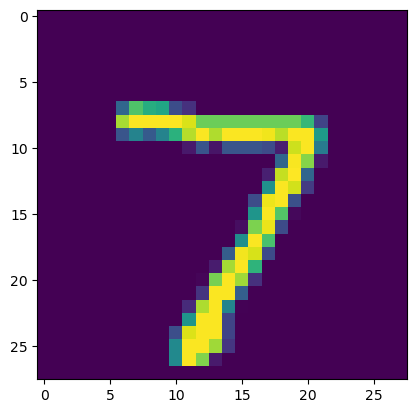

In [12]:
# Visualize a single image
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)[:, :, 0]
gt_lbl = lbls[0]

print(gt_lbl)
plt.imshow(img); plt.show()

## 训练框架: training-loop framework
在神经网络模型框架中一个训练框架(training loop framework), 通过包含如下逻辑:
   1. 随机从训练集里采样出一个batch的样本数据。
   2. 训练步骤(train step):模型基于当前状态参数(state)对于进行预测，得到预测结果的损失函数(loss function),通过反向传播算法更新数据。
   3. 评估步骤:计算与统计训练集上的指标结果。
   4. 每隔一段时间，计算新参数在测试集上的指标结果。
   5. 记录与保存训练与测试指标(train and test metrics)与模型文件。
   


### flax.training与clu指标库
同时，在神经网络训练中我们常用的一种方式是用一个dataclass类来存储与观察整体的训练的状态:
如训练步长(step number), 参数(parameters)与优化器状态(optimizer state)，在flax中， 我们可以常用用flax.training.train_state.TrainState来实现上述的模型训练功能。
而评估，对应于类似sklearn.metrics库，在flax中，我们可以使用clu库用于指标的评估。

In [13]:
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses   
from clu import metrics

In [14]:
@struct.dataclass
class Metric(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

我们先将上述的metrics类传入至train_state.TrainState框架中(用于更简洁地计算损失与指标评估)只需要向train_step等函数传递至一个参数即可以一次性计算损失(calculate the loss与指标(compute the metrics)。
而后，我们创建一个trainStateq:包含了模型的参数， 优化器的状态，预测apply接口以及上述加入的计算指标类。

In [15]:
class TrainState(train_state.TrainState):
    metrics: Metric

def create_train_state(module, rng, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx,metrics=Metric.empty())

我们先实现两个函数模块train_step与eval_step,并用jit机制对其进行优化:
   1. 训练步骤(train_step): train_step主要是根据loss_function的梯度计算结果来更新我们的模型(参数)状态。
   2. 评估步骤(eval_step): 评估模型在我们关心的指标上的表现。

###  训练步骤(training step)
这里我们实现如下train_step函数,其功能包含:
   1. 给定输入的batch图片样本，我们用上述的TrainState里apply_funa功能进行预测(forward pass)
   2. 计算交叉熵损失(cross entropy loss), 这里我们使用softmax_cross_entropy_with_integer_labels(), 这样我们就不需要对原来的图片的label进行one-hot-encoding。
   3. 利用jax.grad计算损失函数的梯度(gradient,pytree结构 )。
   4. 更新模型的参数

同时我们基于JIT机制对其进行加速:

In [16]:
@jax.jit
def train_step(state, image, label):
    """train for a single step"""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

### 指标评估步骤
我们接下来构造eval_step的步骤: 我们关心主要是是平均损失与评估指标,这里是准确度(accuracy)。
loss的计算我们同样使用optax.softmax_cross_entropy_with_integer_labels函数，准确度我们使用clu.metrics来。


In [17]:
@jax.jit
def compute_metrics(*, state, image, label):
    logits = state.apply_fn({'params': state.params}, image)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=label).mean()
    metric_updates = state.metrics.single_from_model_output(logits=logits, labels=label, loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

### 整体训练框架
在Jax中我们需要显式地赋予状态, 函数create_train_state包含了模型参数(model parameters),优化器状态(optimizer)，
我们也需要对其进行赋值。

In [ ]:

init_rng = jax.random.PRNGKey(0)
learning_rate = 0.01
momentum = 0.9
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

training-loop框架

In [28]:
num_epochs = 10
batch_size = 32

num_steps_per_epoch = len(train_lbls)/batch_size

metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}
for epoch in range(num_epochs):
    for step, (imgs, labels) in enumerate(train_loader):
        # Run optimization steps over training batches and compute batch metrics
        state = train_step(state, imgs, labels) # get updated train state (which contains the updated parameters)
        state = compute_metrics(state=state, image=imgs, label=labels) # aggregate batch metrics
    
        if (step) % num_steps_per_epoch == 0: # one training epoch has passed
            for metric,value in state.metrics.compute().items(): # compute metrics
                metrics_history[f'train_{metric}'].append(value) # record metrics
            state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

     # Compute metrics on the test set after each training epoch
    test_state = state
    for _,(imgs, labels) in enumerate(test_loader):
        test_state = compute_metrics(state=test_state, image=imgs, label=labels)

    for metric,value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)
    
    print(f"train epoch: {(step) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 0.0, loss: 0.029766889289021492, accuracy: 99.07352447509766
test epoch: 0.0, loss: 0.028843998908996582, accuracy: 99.13704681396484
train epoch: 0.0, loss: 0.026723409071564674, accuracy: 99.20539855957031
test epoch: 0.0, loss: 0.02685569040477276, accuracy: 99.20011901855469
train epoch: 0.0, loss: 0.024742230772972107, accuracy: 99.2755126953125
test epoch: 0.0, loss: 0.02392951399087906, accuracy: 99.2904281616211
train epoch: 0.0, loss: 0.020968658849596977, accuracy: 99.39070129394531
test epoch: 0.0, loss: 0.023510446771979332, accuracy: 99.3248291015625
train epoch: 0.0, loss: 0.019444843754172325, accuracy: 99.4491195678711
test epoch: 0.0, loss: 0.020095698535442352, accuracy: 99.4251708984375
train epoch: 0.0, loss: 0.017098044976592064, accuracy: 99.52423858642578
test epoch: 0.0, loss: 0.01927335001528263, accuracy: 99.46244049072266
train epoch: 0.0, loss: 0.015641964972019196, accuracy: 99.58434295654297
test epoch: 0.0, loss: 0.0188438780605793, accuracy:

### 可视化结果

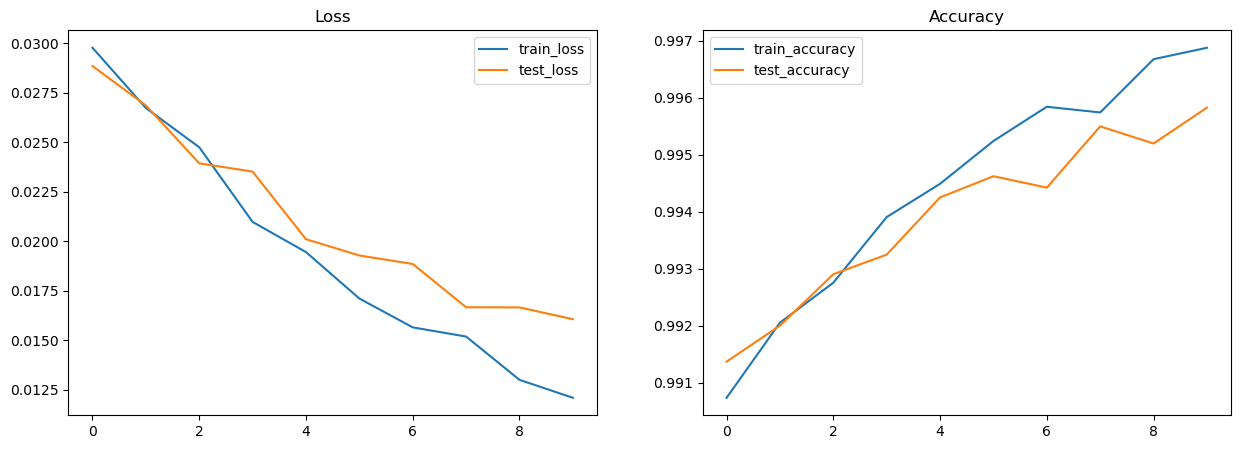

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 总结
在今天的文章，我们展示如何搭建专家级别的flax神经网络模型我们的jax入坑之旅就先告一个段落了。代码链接:(代码链接: https://github.com/oneday88/JaxProgramming)。